In [2]:
import pandas as pd
all_data=pd.read_excel('Final.xlsx')

In [64]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

start_time = time.time()

stock_name = 'Reliance Infrastructure Ltd (RLIN)'
quantity = 1
buying_date = '2024-06-13'
selling_date = '2025-09-15'

filtered_data = all_data[all_data['Stock_Name'] == stock_name]

filtered_data = filtered_data.copy()
filtered_data['Year'] = filtered_data['Date'].dt.year
filtered_data['Month'] = filtered_data['Date'].dt.month
filtered_data['Day'] = filtered_data['Date'].dt.day
filtered_data.dropna(subset=['Date', 'Year', 'Month', 'Day', 'Volume', 'Chg%', 'Close'], inplace=True)

X = filtered_data[['Volume', 'Chg%', 'Year', 'Month', 'Day']]
y = filtered_data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train_poly, y_train)
y_pred=model.predict(X_test_poly)
# X_test['Predicted'] = pd.Series(y_pred,index=X_test.index)

# X_test['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])
y_predt=model.predict(X_train_poly)

# plt.figure(figsize=(30, 10))
# plt.plot(X_test['Date'], X_test['Predicted'], label='Predicted',color='r')
# plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close')

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price')
# plt.legend()
# plt.show()



# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared score:", r2)
print("Adjusted R-squared score:", adj_r2)

filtered_data['Date'] = filtered_data['Date'].astype(str)
filtered_data['Date'] = filtered_data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

# Convert the buying and selling dates to datetime.date objects
buying_date = datetime.datetime.strptime(buying_date, '%Y-%m-%d').date()
selling_date = datetime.datetime.strptime(selling_date, '%Y-%m-%d').date()
print(buying_date,'')
# Get the current date
today_date = datetime.date.today()

# Check the cases and make predictions
if buying_date > today_date and selling_date > today_date:
    # Case 1: Both buying date and selling date in the future
    buying_year = buying_date.year
    buying_month = buying_date.month
    buying_day = buying_date.day
    selling_year = selling_date.year
    selling_month = selling_date.month
    selling_day = selling_date.day

    last_100_data = filtered_data.iloc[-100:]
    volume_mean = np.mean(last_100_data['Volume'])
    chg_mean = np.mean(last_100_data['Chg%'])
    volume_std = np.std(last_100_data['Volume'])
    chg_std = np.std(last_100_data['Chg%'])

    X_buying = np.array([[volume_mean, chg_mean, buying_year, buying_month, buying_day]])
    X_buying_scaled = (X_buying - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
    predicted_close_buying = model.predict(poly.transform(X_buying_scaled))[-1]
    print('Predicted Buying price:', predicted_close_buying)

    X_selling = np.array([[volume_mean, chg_mean, selling_year, selling_month, selling_day]])
    X_selling_scaled = (X_selling - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
    predicted_close_selling = model.predict(poly.transform(X_selling_scaled))[-1]
    print('Predicted Selling price:', predicted_close_selling)

    pnl = (predicted_close_selling - predicted_close_buying) * quantity

elif buying_date > today_date:
    # Case 2: Only buying date in the future
    if selling_date not in filtered_data['Date'].values:
        print("Selling date not found in the dataset.")
        pnl = None
    else:
        buying_year = buying_date.year
        buying_month = buying_date.month
        buying_day = buying_date.day

        last_100_data = filtered_data.iloc[-100:]
        volume_mean = np.mean(last_100_data['Volume'])
        chg_mean = np.mean(last_100_data['Chg%'])
        volume_std = np.std(last_100_data['Volume'])
        chg_std = np.std(last_100_data['Chg%'])

        X_buying = np.array([[volume_mean, chg_mean, buying_year, buying_month, buying_day]])
        X_buying_scaled = (X_buying - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
        predicted_close_buying = model.predict(poly.transform(X_buying_scaled))[-1]
        print('Predicted Buying price:', predicted_close_buying)

        selling_price = filtered_data.loc[filtered_data['Date'] == selling_date, 'Close'].values[0]
        print('Actual Selling price:', selling_price)

        pnl = (selling_price - predicted_close_buying) * quantity

elif selling_date > today_date:
    # Case 3: Only selling date in the future
    if buying_date not in filtered_data['Date'].values:
        print("Buying date not found in the dataset.")
        pnl = None
    else:
        buying_price = filtered_data.loc[filtered_data['Date'] == buying_date, 'Close'].values[0]
        print('Actual Buying price:', buying_price)

        selling_year = selling_date.year
        selling_month = selling_date.month
        selling_day = selling_date.day

        last_100_data = filtered_data.iloc[-100:]
        volume_mean = np.mean(last_100_data['Volume'])
        chg_mean = np.mean(last_100_data['Chg%'])
        volume_std = np.std(last_100_data['Volume'])
        chg_std = np.std(last_100_data['Chg%'])

        X_selling = np.array([[volume_mean, chg_mean, selling_year, selling_month, selling_day]])
        X_selling_scaled = (X_selling - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
        predicted_close_selling = model.predict(poly.transform(X_selling_scaled))[-1]
        print('Predicted Selling price:', predicted_close_selling)

        pnl = (predicted_close_selling - buying_price) * quantity
else:
    # Case 4: None of the dates are in the future
    if buying_date not in filtered_data['Date'].values:
        print("Buying date not found in the dataset.")
        pnl = None
    elif selling_date not in filtered_data['Date'].values:
        print("Selling date not found in the dataset.")
        pnl = None
    else:
        buying_price = filtered_data.loc[filtered_data['Date'] == buying_date, 'Close'].values[0]
        print('Actual Buying price:', buying_price)

        selling_price = filtered_data.loc[filtered_data['Date'] == selling_date, 'Close'].values[0]
        print('Actual Selling price:', selling_price)

        pnl = (selling_price - buying_price) * quantity

# Display the P&L if it exists
if pnl is not None:
    print("Profit/Loss:", pnl)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


R-squared score: 0.8651190806591983
Adjusted R-squared score: 0.8616957070718683
2024-06-13 
Predicted Buying price: 196.67899054977897
Predicted Selling price: 255.95842369121965
Profit/Loss: 59.27943314144068
Elapsed time: 0.31248927116394043 seconds


C:\Users\Mayan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Mayan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


C:\Users\Mayan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mayan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


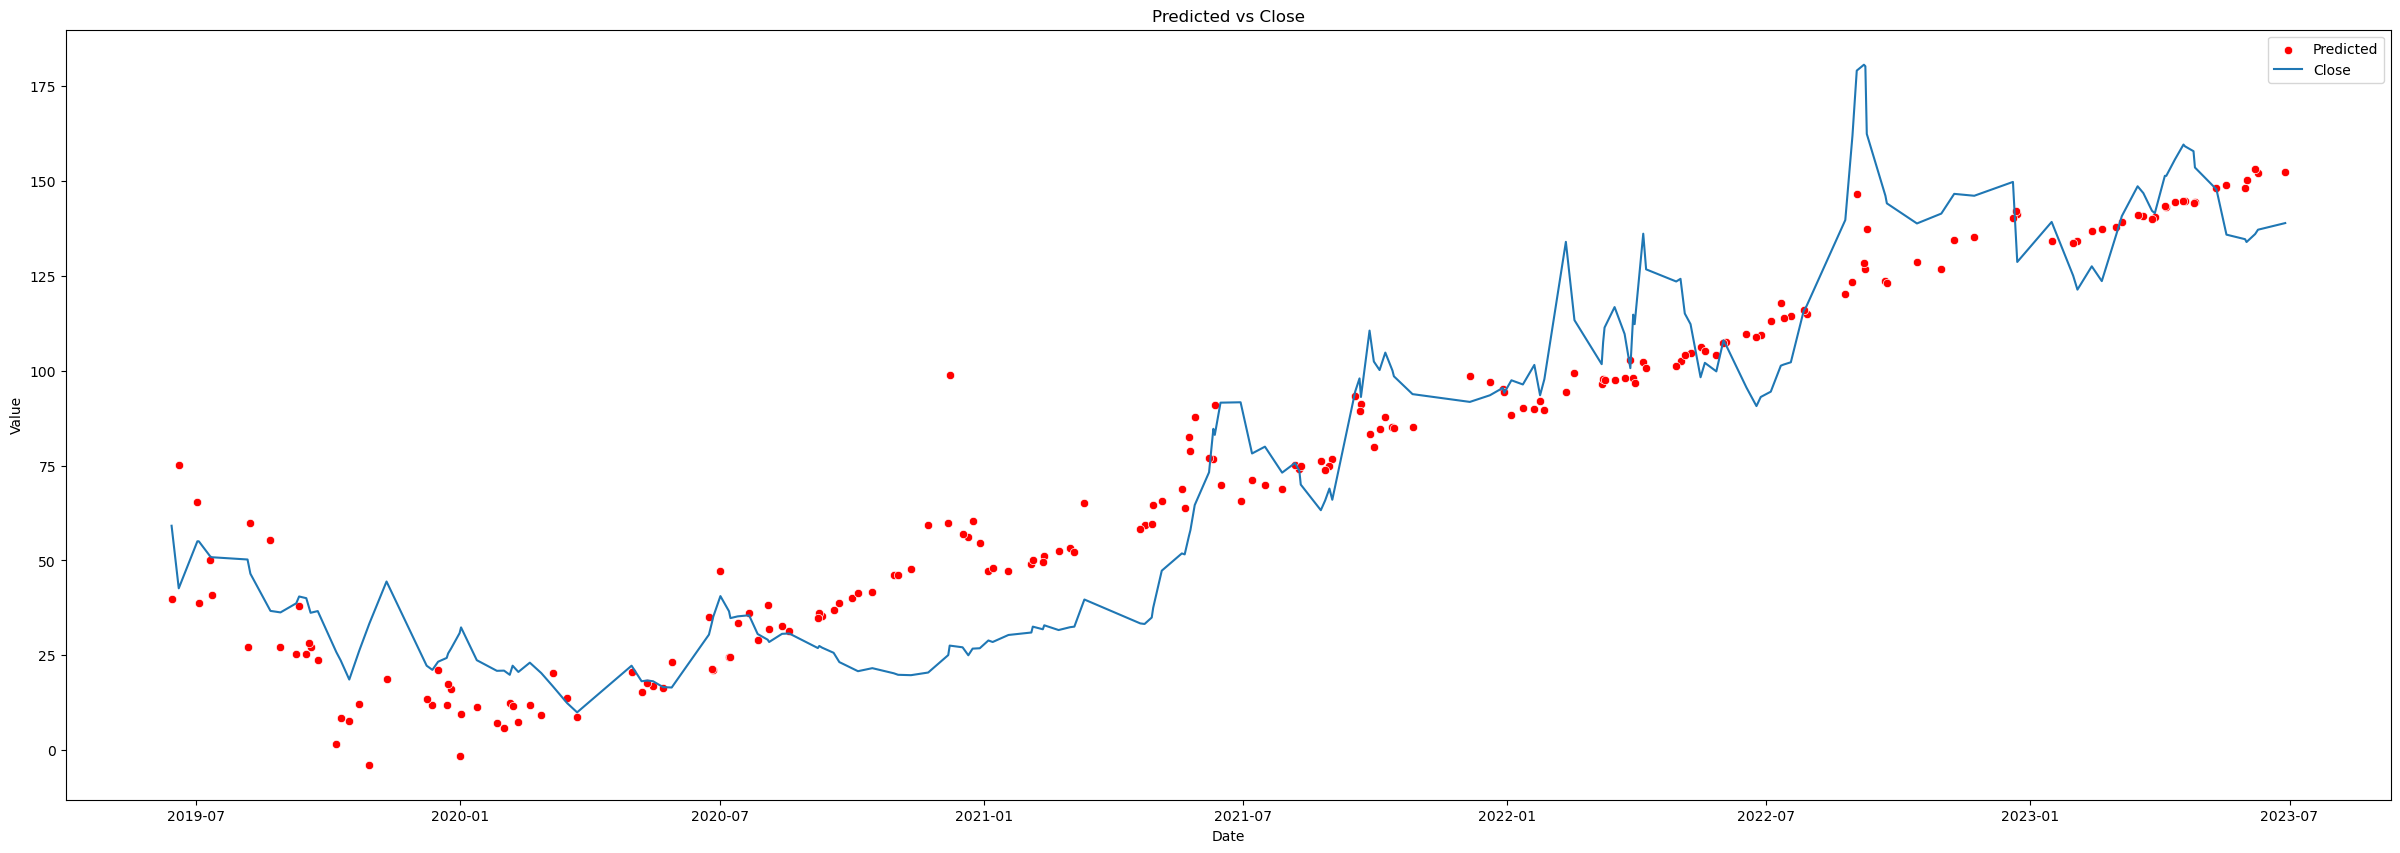

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 10))
sns.scatterplot(X_test['Date'], X_test['Predicted'], label='Predicted', color='r')
sns.lineplot(X_test['Date'], X_test['Close'], label='Close')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Close')

plt.show()


In [4]:
X_test['Close'] = y_test.values


In [8]:
X_test

,Volume,Chg%,Year,Month,Day,Predicted,Date,Close
38117,3630000.0,4.90,2020,12,24,60.528659,2020-12-24,26.75
38120,2230000.0,-4.94,2020,12,21,56.149380,2020-12-21,25.00
38450,26780000.0,-12.62,2019,8,22,55.382846,2019-08-22,36.70
38111,4360000.0,4.90,2021,1,4,47.252985,2021-01-04,28.90
37851,1530000.0,1.80,2022,1,20,90.042247,2022-01-20,101.55
...,...,...,...,...,...,...,...,...
38153,1280000.0,-1.98,2020,11,2,46.097487,2020-11-02,19.85
37696,6180000.0,1.09,2022,9,7,128.297588,2022-09-07,180.70
38068,2190000.0,1.09,2021,3,5,52.222967,2021-03-05,32.55
37564,10470000.0,5.24,2023,3,17,141.063295,2023-03-17,148.65


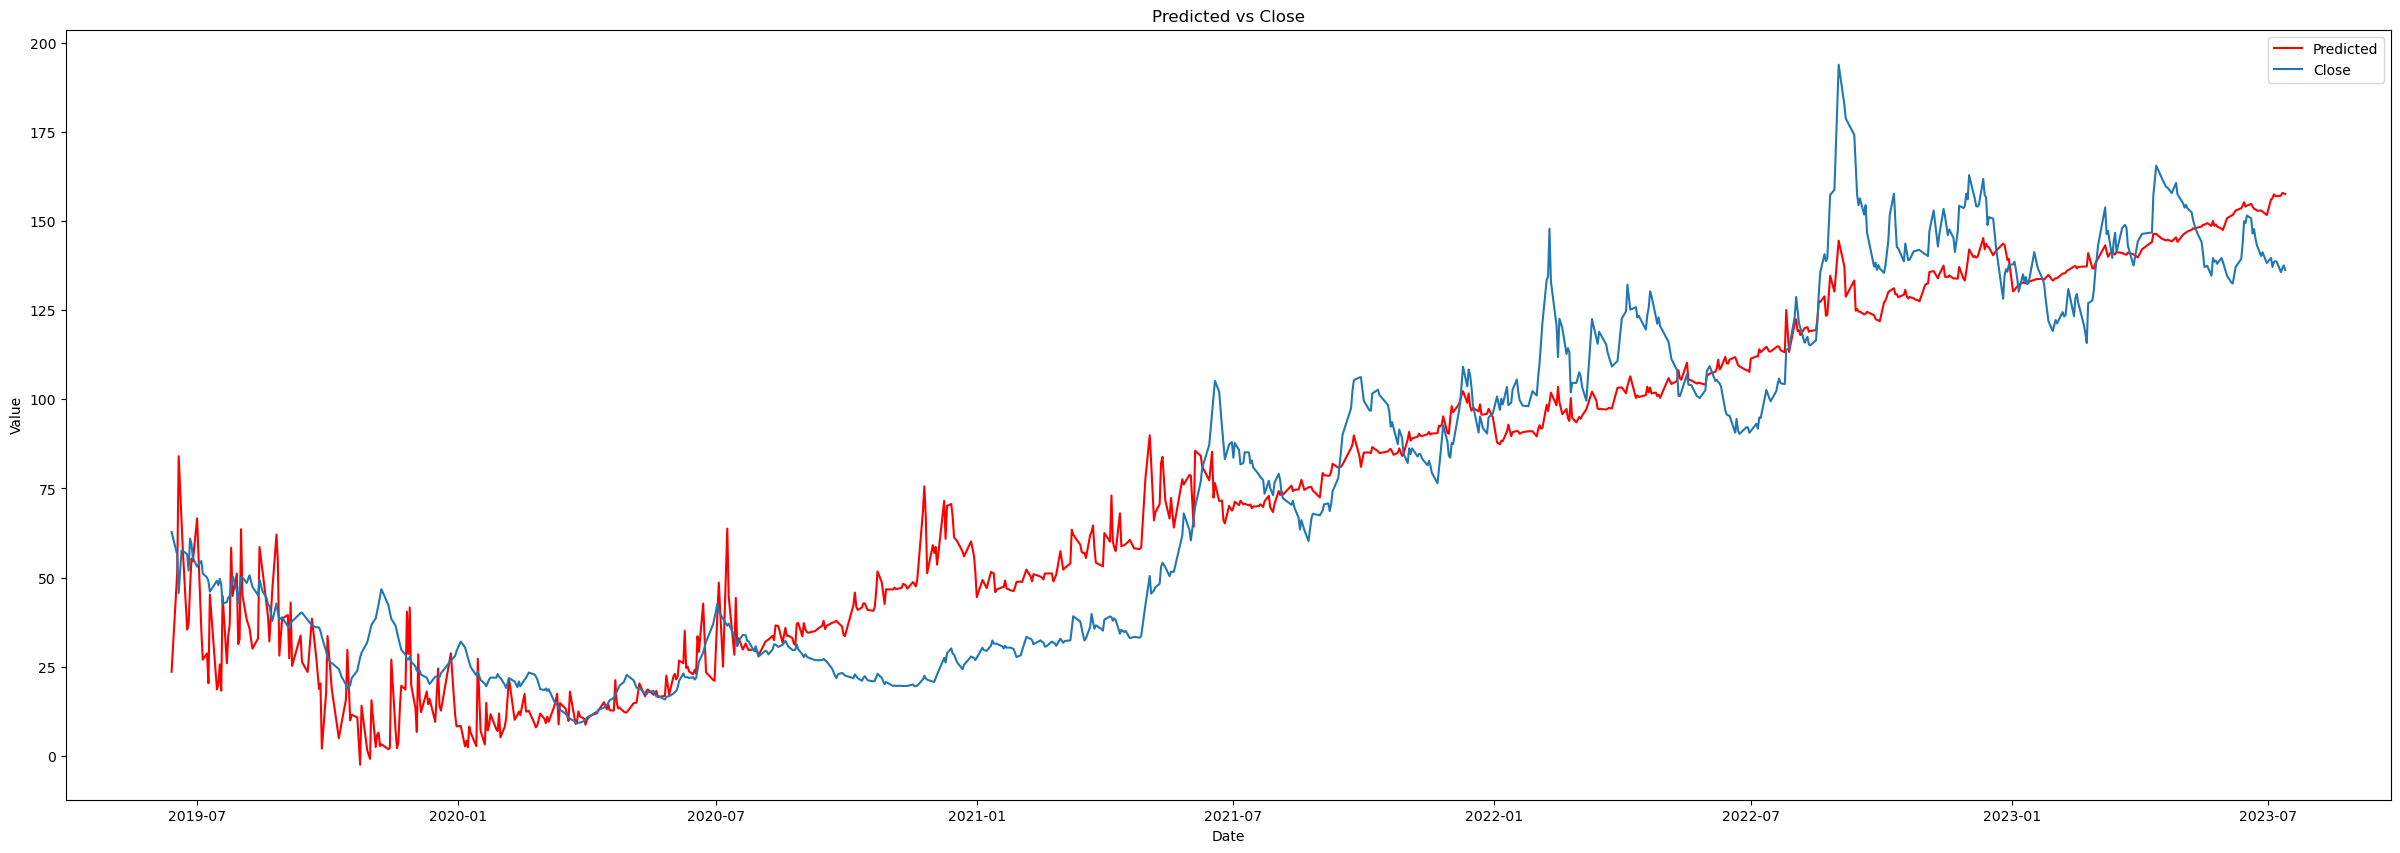

In [65]:
# Final
X_train['Close'] = y_train.values
X_train['Predicted'] = pd.Series(y_predt,index=X_train.index)
X_train['Date'] = pd.to_datetime(X_train[['Year', 'Month', 'Day']])
y_predt=model.predict(X_train_poly)

X_train_sorted = X_train.sort_values('Date')

plt.figure(figsize=(30, 10))
plt.plot(X_train_sorted['Date'], X_train_sorted['Predicted'], label='Predicted', color='r')
plt.plot(X_train_sorted['Date'], X_train_sorted['Close'], label='Close')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Close')

plt.show()